In [1]:
import os
from pathlib import Path

PHENOTYPE_FOLDER = Path("/local/scratch/carlyn.1/dna/colors/processed")
GENOME_FOLDER = Path("/local/scratch/carlyn.1/dna/vcfs/processed/genome")
DATA_SPLIT_FOLDER = Path("/home/carlyn.1/dna-trait-analysis/data")
RESULTS_FOLDER = Path("/local/scratch/carlyn.1/dna/results/testing/")
PLOT_RESULTS_FOLDER = Path("/home/carlyn.1/dna-trait-analysis/plot_results")
BATCH_SIZE = 8
DEVICES = "6"
REDO = False

os.environ["CUDA_VISIBLE_DEVICES"]=DEVICES
ex_path = "/local/scratch/carlyn.1/dna/results/whole_genome/erato_forewings_color_3_chromosome_18"



In [2]:
import os
import json

import pandas as pd
import numpy as np
import torch

from scipy.stats import pearsonr
from captum.attr import GuidedGradCam

from gtp.evaluation import get_lrp_attr
from gtp.dataloading.tools import (
    load_chromosome_data,
    split_data_by_file,
)

def load_data(phenotype_folder, genome_folder, split_data_folder, chromosome, species, wing, color, out_dims_start_idx=0, out_dims=1):
    camids_aligned, genotype_data_aligned, phenotype_data_aligned = (
        load_chromosome_data(
            genome_folder,
            phenotype_folder,
            species,
            wing,
            color,
            chromosome,
        )
    )

    phenotype_data_aligned = phenotype_data_aligned[
        :, out_dims_start_idx : out_dims_start_idx + out_dims
    ]

    train_split, val_split, test_split = split_data_by_file(
        genotype_data_aligned,
        phenotype_data_aligned,
        camids_aligned,
        split_data_folder,
        species,
    )

    return train_split, val_split, test_split

def calc_pearson_correlation(model, dloader, index=0):
    model.eval()
    actual = []
    predicted = []
    for i, batch in enumerate(dloader):
        model.zero_grad()
        data, pca = batch
        out = model(data.cuda())
        actual.extend(pca[:, index].detach().cpu().numpy().tolist())
        predicted.extend(out[:, index].detach().cpu().numpy().tolist())
    return pearsonr(predicted, actual)

def compile_attribution(attr):
    attr, _ = torch.abs(attr).max(-1)
    attr = attr[:, 0] # Only has 1 channel, just extract it
    attr = attr.detach().cpu().numpy()
    attr = np.median(np.abs(attr), 0) # median across batch???
    #attr = attr.sum(0) # Sum across batch...Should we be summing here???
    return attr

def get_saliency_attr(m, dloader, target=0):
    att_model = GuidedGradCam(m, m.last_block)
    attr_total = None
    for i, batch in enumerate(dloader):
        m.zero_grad()
        data, pca = batch
        attr = att_model.attribute(data.cuda(), target=target)
        attr = compile_attribution(attr)
        if attr_total is None:
            attr_total = attr
        else:
            attr_total += attr

    #attr_total = attr_total / np.linalg.norm(attr_total, ord=1) # Normalize
    return attr_total

def load_json_attributes(path):
    with open(path, 'r') as f:
        return json.load(f)
    
def save_json_attributes(path, data):
    with open(path, 'w') as f:
        json.dump(data, f)

In [3]:
import os

import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

from gtp.dataloading.datasets import GTP_Dataset
from gtp.models.net import SoyBeanNetDeep

def compute_and_save_data(species, wing, color, results_dir, chromosome=18, target_index=0, skip_loading=False):
    os.makedirs(results_dir, exist_ok=True)
    chromo_results = []
    chromo_pvals = []
    attributions = []

    if REDO or not os.path.exists(os.path.join(results_dir, "chromosome_summary_pearson.npy")):
        train_data, val_data, test_data = load_data(PHENOTYPE_FOLDER, GENOME_FOLDER, DATA_SPLIT_FOLDER, 
                chromosome, species, wing, color, out_dims_start_idx=0, out_dims=1)

        train_dataset = GTP_Dataset(*train_data)
        val_dataset = GTP_Dataset(*val_data)
        test_dataset = GTP_Dataset(*test_data)

        num_vcfs = train_data[0].shape[1]

        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)

        model = SoyBeanNetDeep(window_size=num_vcfs, num_out_dims=1, insize=3, hidden_dim=10, drop_out_prob=0.75)
        model_path = RESULTS_FOLDER / Path(f"{species}_{wing}_{color}_chromosome_{chromosome}/model.pt")
        model.load_state_dict(torch.load(model_path))
        model = model.cuda()
        model.eval()

        with torch.no_grad():
            #tr_pearson_stat, _ = calc_pearson_correlation(model, train_dataloader, DEVICE)
            val_pearson_stat, val_pv = calc_pearson_correlation(model, val_dataloader)
            test_pearson_stat, test_pv = calc_pearson_correlation(model, test_dataloader)
        #val_att = get_saliency_attr(model, val_dataloader, DEVICE, target=target_index)
        #test_att = get_saliency_attr(model, test_dataloader, DEVICE, target=target_index)
        val_att = get_lrp_attr(model, val_dataloader, target=target_index)
        test_att = get_lrp_attr(model, test_dataloader, target=target_index)
        attributions.append([val_att.tolist(), test_att.tolist()])
        chromo_results.append([val_pearson_stat, test_pearson_stat])
        chromo_pvals.append([f"{val_pv:.2e}", f"{test_pv:.2e}"])
        
        print(f"Chromosome: {chromosome} - Pearson | (val) {val_pearson_stat} ({val_pv:.2e}) | (test) {test_pearson_stat} ({test_pv:.2e})")
            
        np.save(os.path.join(results_dir, "chromosome_summary_pearson.npy"), chromo_results)
        np.save(os.path.join(results_dir, "chromosome_summary_pvals.npy"), chromo_pvals)
        save_json_attributes(os.path.join(results_dir, "chromosome_attributions.json"), attributions)
    else:
        if skip_loading:
            return None, None, None
        chromo_results = np.load(os.path.join(results_dir, "chromosome_summary_pearson.npy"))
        chromo_pvals = np.load(os.path.join(results_dir, "chromosome_summary_pvals.npy"))
        attributions = load_json_attributes(os.path.join(results_dir, "chromosome_attributions.json"))
        
    return chromo_results, chromo_pvals, attributions

In [4]:
target_index = 0
chromosome = 18

species = "erato"
wing = "forewings"
color = "color_3"

print(f"Calculating attributions for: {species}-{wing}-{color}")
results_dir = PLOT_RESULTS_FOLDER / f"testing_pvalue_{species}_{wing}_{color}"
chromo_results, chromo_pvals, attributions = compute_and_save_data(species, wing, color, results_dir, chromosome=chromosome, target_index=target_index, skip_loading=True)

Calculating attributions for: erato-forewings-color_3


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


Chromosome: 18 - Pearson | (val) 0.8879707465531683 (8.75e-17) | (test) 0.9435158228500871 (3.47e-24)


In [7]:
species = "erato"
wing = "forewings"
color = "color_3"
results_dir = PLOT_RESULTS_FOLDER / f"testing_pvalue_{species}_{wing}_{color}"

chromo_results = np.load(os.path.join(results_dir, "chromosome_summary_pearson.npy"))
chromo_pvals = np.load(os.path.join(results_dir, "chromosome_summary_pvals.npy"))
attributions = load_json_attributes(os.path.join(results_dir, "chromosome_attributions.json"))

/tmp/ipykernel_1225559/2451816730.py:24: RuntimeWarning: invalid value encountered in divide
  p_values_normalized = (p_values - p_values.min()) / (p_values.max() - p_values.min())
Running Linear regression on SNPS: 100%|██████████| 2000/2000 [00:24<00:00, 81.18it/s] 
/tmp/ipykernel_1225559/2451816730.py:24: RuntimeWarning: invalid value encountered in divide
  p_values_normalized = (p_values - p_values.min()) / (p_values.max() - p_values.min())
Running Linear regression on SNPS: 100%|██████████| 2000/2000 [00:07<00:00, 274.86it/s]


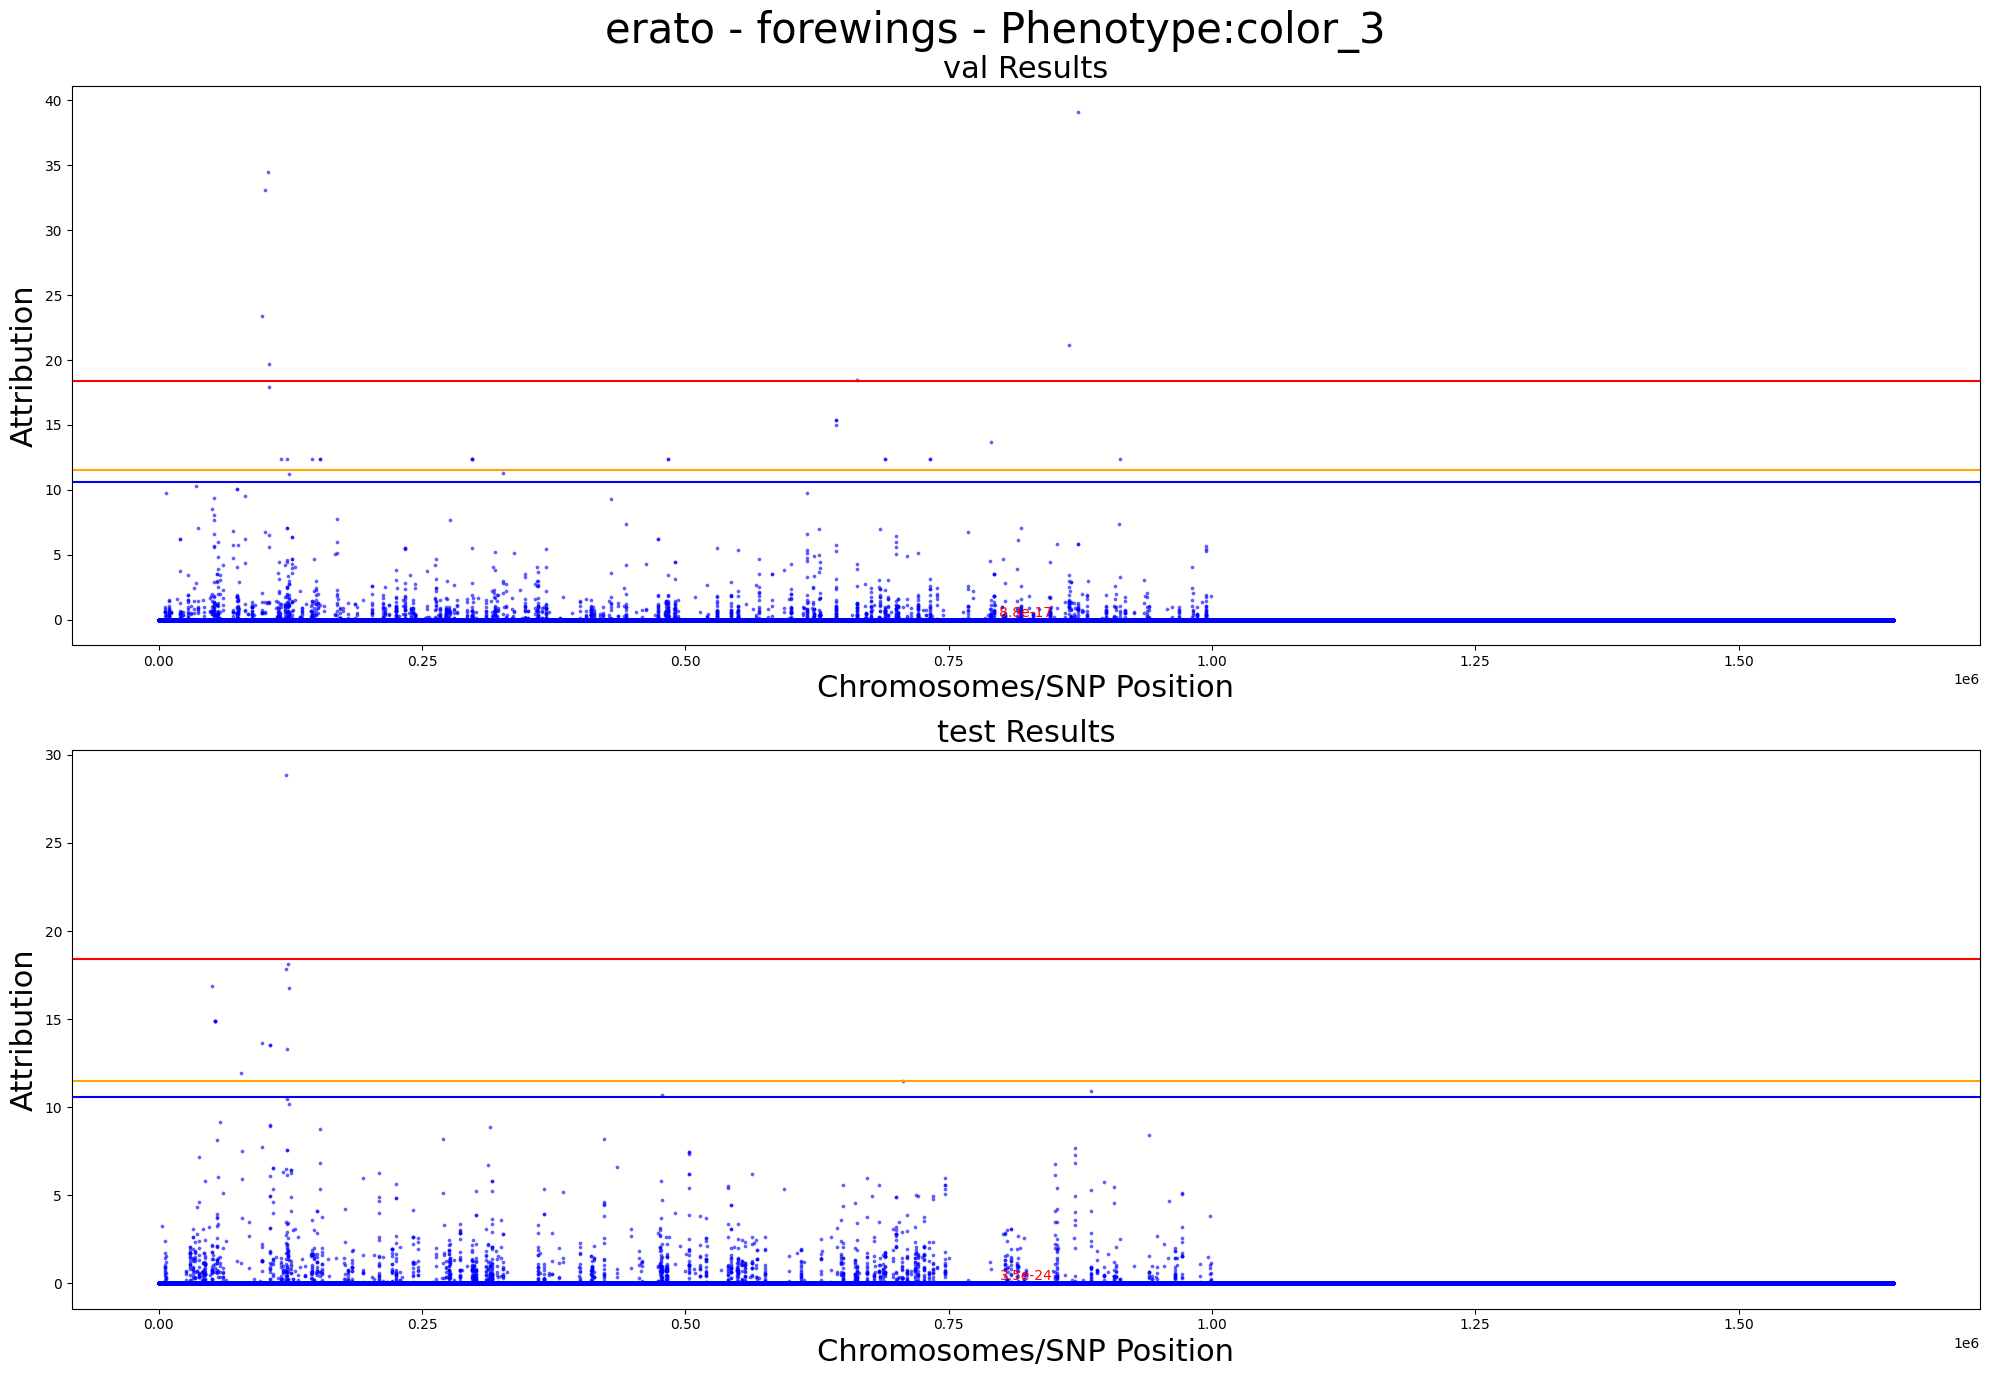

In [8]:
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from gtp.tools import calc_pvalue_linear, filter_topk_snps, profile_exe_time

bar_colors = [
    (1, 0, 0),
    (0, 0, 1)
] # go from red to blue (significant to least significant)

pos = [0.0, 1.0]
bar_cmap = LinearSegmentedColormap.from_list('custom_colormap', 
                                                list(zip(pos, bar_colors)))

fig, axs = plt.subplots(2, 1, figsize=(20, 14))
fig.suptitle(f"{species} - {wing} - Phenotype:{color}", fontsize=30)

alt_colors = ["blue", "grey"]
for pi, phase in enumerate(["val", "test"]):
    start_pos = 0
    chromo_pvals = np.array(chromo_pvals)
    p_values = chromo_pvals[:, pi].astype(np.float64)
    p_values_normalized = (p_values - p_values.min()) / (p_values.max() - p_values.min())
    p_values_normalized = 1 - p_values_normalized
    x_mid_points = []
    sig_lines = []
    dset = _, val_data, test_data = load_data(PHENOTYPE_FOLDER, GENOME_FOLDER, DATA_SPLIT_FOLDER, 
        chromosome, species, wing, color, out_dims_start_idx=0, out_dims=1)
    chromo_data = np.array(attributions[0][pi])
    num_pos = chromo_data.shape[0]
    X = np.arange(num_pos) + start_pos
    
    top_k_idx = filter_topk_snps(chromo_data, k=2000)
    
    dset = None
    if phase == "val":
        dset = GTP_Dataset(*val_data)
    elif phase == "test":
        dset = GTP_Dataset(*test_data)
    
    pvals = calc_pvalue_linear(
        np.take(dset.genotype_data, indices=top_k_idx, axis=1),
        dset.phenotype_data[:, 0],
    )
    all_pvals = np.ones(num_pos)
    all_pvals[top_k_idx] = pvals
    
    sig_lines.append([start_pos, X[-1], -np.log(0.05/num_pos)])
    
    #adjust_val = p_values_normalized[ci]
    #Y = chromo_data
    Y = -np.log(all_pvals)
    start_pos = X[-1]
    bar_plots = axs[pi].scatter(X, Y, alpha=0.5, s=3, color=alt_colors[0 % 2 == 1])
    axs[pi].set_title(f"{phase} Results", fontsize=22)
    axs[pi].set_xlabel("Chromosomes/SNP Position", fontsize=22)
    axs[pi].set_ylabel("Attribution", fontsize=22)
    #axs[pi].axhline(y=-np.log(0.05 / num_pos), color="green")
    mid_point = X[X.shape[0]//2]
    x_mid_points.append(mid_point)
    axs[pi].text(
        mid_point, 0, 
        f"{p_values[0]:.1e}", ha="center", va="bottom", rotation=0, color="red"
    )
        
    axs[pi].axhline(y=-np.log(1e-8), color="red")
    axs[pi].axhline(y=-np.log(1e-5), color="orange")
    axs[pi].axhline(y=-np.log(0.05 / 2000), color="blue")

fig.tight_layout()

plt.savefig(os.path.join(results_dir, f"genome_detail_{species}_{wing}_{color}.png"))
plt.show()
        
    

/tmp/ipykernel_1091874/282410606.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PuBu_r')


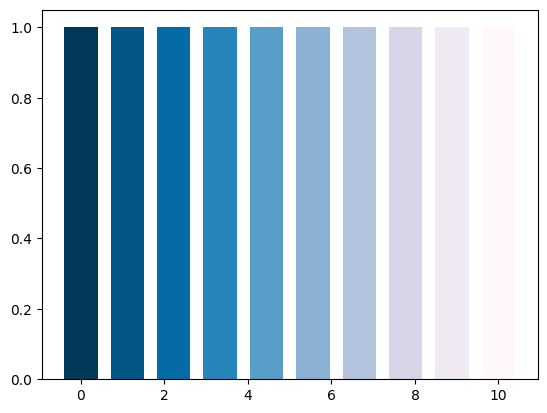

"\n# A low hump with a spike coming out of the top right.  Needs to have\n# z/colour axis on a log scale, so we see both hump and spike. A linear\n# scale only shows the spike.\nZ1 = np.exp(-X**2 - Y**2)\nZ2 = np.exp(-(X * 10)**2 - (Y * 10)**2)\nZ = Z1 + 50 * Z2\n\nfig, ax = plt.subplots(2, 1)\n\npcm = ax[0].pcolor(X, Y, Z,\n                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),\n                   cmap='PuBu_r', shading='auto')\nfig.colorbar(pcm, ax=ax[0], extend='max')\n\npcm = ax[1].pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')\nfig.colorbar(pcm, ax=ax[1], extend='max')\nplt.show()\n"

In [7]:
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

cmap = cm.get_cmap('PuBu_r')
log_norm = colors.LogNorm()

X = np.linspace(0, 10, 10)
Y = np.logspace(0, 1e-6, 10, base=1e-20)[::-1]

fig, ax = plt.subplots(1, 1)
ax.bar(X, Y, color=cmap(log_norm(Y)))
plt.show()


"""
# A low hump with a spike coming out of the top right.  Needs to have
# z/colour axis on a log scale, so we see both hump and spike. A linear
# scale only shows the spike.
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
Z = Z1 + 50 * Z2

fig, ax = plt.subplots(2, 1)

pcm = ax[0].pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=ax[0], extend='max')

pcm = ax[1].pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=ax[1], extend='max')
plt.show()
"""